3
CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBABILITY VECTORS...
(1080, 3) (1080, 3)
CALCULATING ENTROPY VECTORS...
CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBABILITY VECTORS...
(12000, 3) (12000, 3)
CALCULATING ENTROPY VECTORS...
CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBABILITY VECTORS...
(23143, 3) (23143, 3)
CALCULATING ENTROPY VECTORS...
CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBABILITY VECTORS...
(36000, 3) (36000, 3)
CALCULATING ENTROPY VECTORS...
CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBABILITY VECTORS...
(46286, 3) (46286, 3)
CALCULATING ENTROPY VECTORS...
CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBABILITY VECTORS...
(64800, 3) (64800, 3)
CALCULATING ENTROPY VECTORS...
CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBABILITY VECTORS...
(81000, 3) (81000, 3)
CALCULATING ENTROPY VECTORS...
CALCULATING PROBABILITY VECTORS...
CALCULATING JOINT PROBABILITY VECTORS...
(81000, 3) (81000, 3)

IndexError: index 27 is out of bounds for axis 0 with size 25

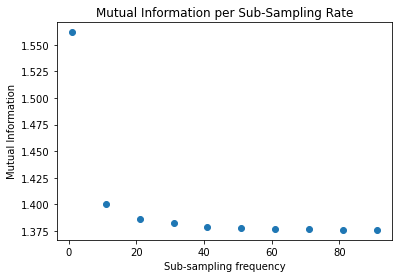

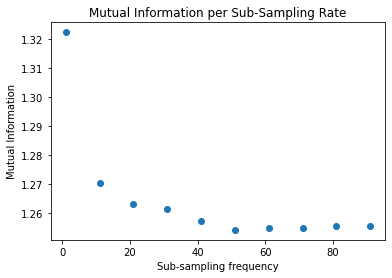

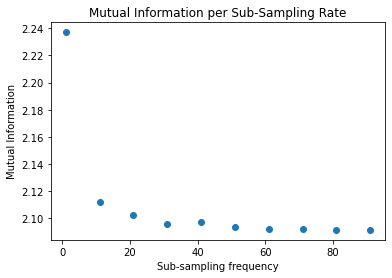

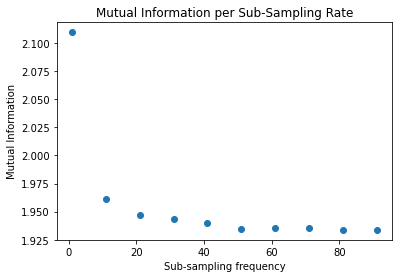

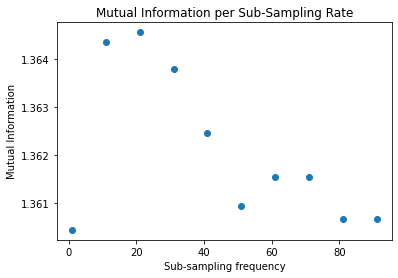

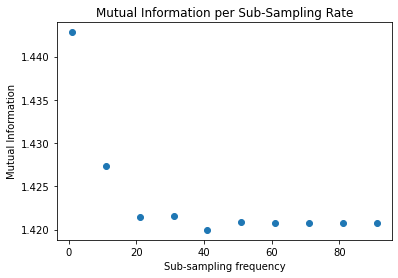

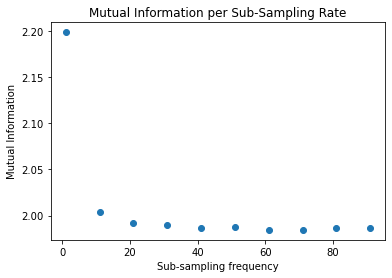

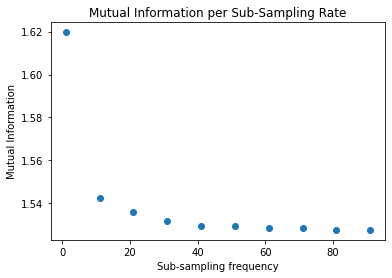

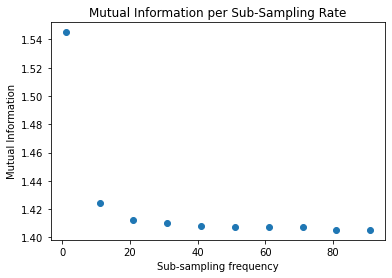

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import scipy.special as psi

from scipy.io import loadmat
from scipy import stats
from scipy.spatial import distance
from scipy.stats import entropy
from prob_util import *
from entropy_util import *

## THIS SCRIPTS IS USED TO FIND THE OPTIMAL SUB-SAMPLING RATE
## OF THE HIGH-D TRAJECTORIES BEFORE PCA APPLICATION

# loading entire high-dimensional trajectory
path = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/normal/traj_1/trajectories/'
trajectories = os.listdir(path)

# parameters
how_many = 3
markers = [11, 15]
fs_og = 300
sub_fs = np.arange(1, 100, 10)
MIs = np.zeros((int(len(trajectories)/how_many), len(sub_fs)))
MIs_max = np.zeros((int(len(trajectories)/how_many), 1))
nan_cols = [12,13,14]
cnt = 0

# loading normalized data and removing invalid values (e.g. NaN)
for traj, time_bin in enumerate(trajectories):
    trajectory = loadmat(path + time_bin)
    trajectory = trajectory['trajectory'] 
    trajectory = np.delete(trajectory, nan_cols, 1)
    if traj == 0 or traj % how_many == 1:
        sequence = trajectory
    if traj % how_many > 1:
        sequence = np.concatenate((sequence, trajectory), 0)
    elif traj % how_many == 0 and traj > 0:
        print(traj)
        sequence = np.concatenate((sequence, trajectory), 0)
        plt.figure(traj)
        for i, fs in enumerate(sub_fs):
            # step for sampling frequency
            step = int(300/fs)

            # construct sample trajectories for the first 2 dims ('HeadF' and 'HeadB')
            s1 = sequence[0:sequence.shape[0]:step, markers[0]*3:(markers[0]*3)+3]
            s2 = sequence[0:sequence.shape[0]:step, markers[1]*3:(markers[1]*3)+3]

            # probability vectors for the two sequences and joint probability
            print('CALCULATING PROBABILITY VECTORS...')
            prob_s1 = probability(s1)
            prob_s2 = probability(s2)
            print('CALCULATING JOINT PROBABILITY VECTORS...') 
            prob_s1s2 = joint_probability(s1, s2) 
            print(s1.shape, s2.shape)

            # calculating entropy values for MI
            print('CALCULATING ENTROPY VECTORS...')
            E_s1 = entropy(prob_s1, base=2)
            E_s2 = entropy(prob_s2, base=2)
            E_s1_cond_s2 = joint_entropy(prob_s1s2) - E_s2
            MI = E_s1 - E_s1_cond_s2
            MIs[cnt, i] = MI

        # plotting relation between MI and sub-sampling frequency    
        plt.scatter(sub_fs, MIs[cnt, :])
        plt.ylabel('Mutual Information')
        plt.xlabel('Sub-sampling frequency')
        plt.title("Mutual Information per Sub-Sampling Rate")
        name = "MI_subsampling_" + str(int(traj/3)) + ".jpg"
        path_out = "/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/normal/traj_1/images/"
        plt.savefig(path_out + name)
        idx = np.where(MIs[cnt, :] == np.max(MIs[cnt, :]))[0][0]
        MIs_max[traj] = sub_fs[idx]
        cnt +=1
    
np.save("/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/normal/traj_1/MIs_max", MIs_max)
np.save("/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/normal/traj_1/MIs", MIs)